In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pycaret.time_series import TSForecastingExperiment
import plotly.graph_objects as go
import math
from plotly.subplots import make_subplots
from datetime import datetime
import sys  
from pathlib import Path
from pycaret.regression import *
import shap
import matplotlib.pyplot as plt
import logging
import pickle

# Add project root to path (assuming notebook is in the notebooks directory)
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# Local imports
from src.core.bloomberg_fetcher import fetch_bloomberg_data
from src import trans_utils  # Using the one from src root since that's what you have open
from src.utils import merge_utils  # Using the one from utils since that's what you have open
from src.utils.csv_exporter import export_to_csv

In [2]:
# Getting all the data 
mapping = {
    ('I05510CA Index', 'INDEX_OAS_TSY_BP'): 'cad_oas',
    ('LF98TRUU Index', 'INDEX_OAS_TSY_BP'): 'us_hy_oas',
    ('LUACTRUU Index', 'INDEX_OAS_TSY_BP'): 'us_ig_oas',
    ('SPTSX Index', 'PX_LAST'): 'tsx',
    ('VIX Index', 'PX_LAST'): 'vix',
    ('USYC3M30 Index', 'PX_LAST'): 'us_3m_10y',
    ('BCMPUSGR Index', 'PX_LAST'): 'us_growth_surprises',
    ('BCMPUSIF Index', 'PX_LAST'): 'us_inflation_surprises',
    ('LEI YOY  Index', 'PX_LAST'): 'us_lei_yoy',
    ('.HARDATA G Index', 'PX_LAST'): 'us_hard_data_surprises',
    ('CGERGLOB Index', 'PX_LAST'): 'us_equity_revisions',
    ('.ECONREGI G Index', 'PX_LAST'): 'us_economic_regime',
 
}

# Calculate dates
end_date = datetime.now().strftime('%Y-%m-%d')
start_date ='2002-01-01'

# Fetch the data
df = fetch_bloomberg_data(
    mapping=mapping,
    start_date=start_date,
    end_date=end_date,
    periodicity='M',
    align_start=True
).dropna()

# Getting all the er_ytd data 
mapping1 = {
    ('I05510CA Index', 'INDEX_EXCESS_RETURN_YTD'): 'cad_ig_er',
    ('LF98TRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_hy_er',
    ('LUACTRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_ig_er',
}

# Fetch the er_ytd_data
df1 = fetch_bloomberg_data(
    mapping=mapping1,
    start_date=start_date,
    end_date=end_date,
    periodicity='M',
    align_start=True
).dropna()

# Conver er_ytd data to an index
df2= trans_utils.convert_er_ytd_to_index(df1[['cad_ig_er','us_hy_er','us_ig_er']])
final_df=merge_utils.merge_dfs(df, df2, fill='ffill', start_date_align='yes')

# Handle bad data point for cad_oas on Nov 15 2005
bad_date = '2005-11-15'
if bad_date in final_df.index:
    final_df.loc[bad_date, 'cad_oas'] = final_df.loc[final_df.index < bad_date, 'cad_oas'].iloc[-1]


#  Fill the first row with 100 (starting index value)
final_df[['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index']] = final_df[['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index']].fillna(100)
# Drop the er_index columns
final_df = final_df.drop(['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index'], axis=1)


# Calculate TSX percent changes for different periods
final_df['tsx_1m'] = final_df['tsx'].pct_change(periods=1) * 100
final_df['tsx_3m'] = final_df['tsx'].pct_change(periods=3) * 100
final_df['tsx_6m'] = final_df['tsx'].pct_change(periods=6) * 100
final_df['tsx_12m'] = final_df['tsx'].pct_change(periods=12) * 100

# Drop the original tsx column
final_df = final_df.drop('tsx', axis=1)

# Drop any NA rows that resulted from the calculations
final_df = final_df.dropna()

# Export the final DataFrame to CSV, overwriting if exists
export_path = export_to_csv(
    data=final_df,
    name='monthly_oas_pycaret',
    export_dir='c:/Users/Eddy/Documents/auto_ml/csv_outputs',
    overwrite=True  # Explicitly set to overwrite existing file
)

print(final_df.info())
print('-----------------------------')
print('-----------------------------')
print(final_df.head())
print('-----------------------------')
print('-----------------------------')
print(final_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 2003-08-29 to 2025-01-31
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cad_oas                 332 non-null    float64
 1   us_hy_oas               332 non-null    float64
 2   us_ig_oas               332 non-null    float64
 3   vix                     332 non-null    float64
 4   us_3m_10y               332 non-null    float64
 5   us_growth_surprises     332 non-null    float64
 6   us_inflation_surprises  332 non-null    float64
 7   us_lei_yoy              332 non-null    float64
 8   us_hard_data_surprises  332 non-null    float64
 9   us_equity_revisions     332 non-null    float64
 10  us_economic_regime      332 non-null    float64
 11  tsx_1m                  332 non-null    float64
 12  tsx_3m                  332 non-null    float64
 13  tsx_6m                  332 non-null    float64
 14  tsx_12m                

2025-02-17 16:14:37,009 - INFO - Loading data from c:/Users/Eddy/Documents/auto_ml/csv_outputs/monthly_oas_pycaret.csv
2025-02-17 16:14:37,014 - INFO - Data loaded successfully. Shape: (332, 15)
2025-02-17 16:14:37,015 - INFO - Analyzing feature correlations



Feature Correlations with Target (cad_oas):
cad_oas                   1.000000
us_ig_oas                 0.891147
us_hy_oas                 0.877671
vix                       0.725290
us_3m_10y                 0.160614
us_inflation_surprises    0.058748
tsx_1m                   -0.206879
us_hard_data_surprises   -0.237727
us_growth_surprises      -0.314469
tsx_3m                   -0.395166
tsx_6m                   -0.591158
us_equity_revisions      -0.631393
us_economic_regime       -0.677868
us_lei_yoy               -0.698789
tsx_12m                  -0.763952
Name: cad_oas, dtype: float64


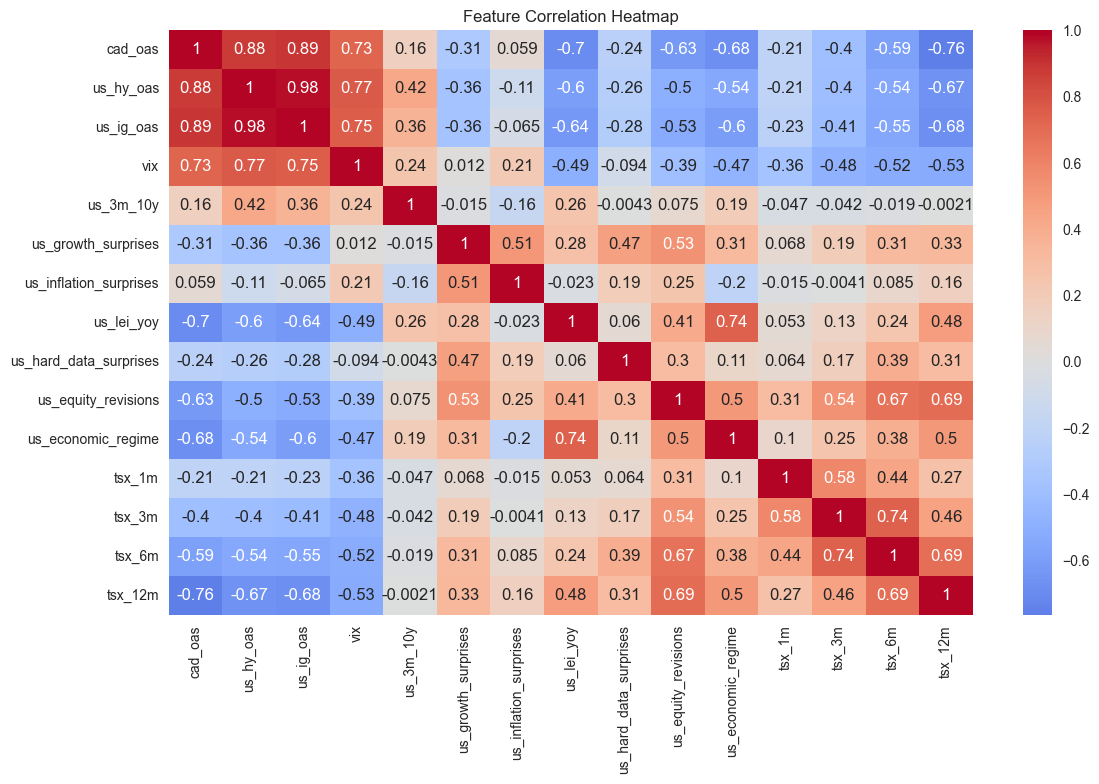

2025-02-17 16:14:37,369 - INFO - Initializing model setup


,Description,Value
0,Session id,123
1,Target,cad_oas
2,Target type,Regression
3,Original data shape,"(332, 15)"
4,Transformed data shape,"(332, 15)"
5,Transformed train set shape,"(265, 15)"
6,Transformed test set shape,"(67, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


2025-02-17 16:14:38,369 - INFO - Training and evaluating models on test set



Features being used in the model:
['us_hy_oas', 'us_ig_oas', 'vix', 'us_3m_10y', 'us_growth_surprises', 'us_inflation_surprises', 'us_lei_yoy', 'us_hard_data_surprises', 'us_equity_revisions', 'us_economic_regime', 'tsx_1m', 'tsx_3m', 'tsx_6m', 'tsx_12m']

Training lr...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,15.8181,408.9711,20.2230,0.7669,0.2225,0.1563


Test Set Metrics for lr:
MAPE: 15.63%
RMSE: 20.22
MAE: 15.82
R²: 0.7669

Training en...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,15.4751,376.9870,19.4162,0.7851,0.2065,0.1553


Test Set Metrics for en:
MAPE: 15.53%
RMSE: 19.42
MAE: 15.48
R²: 0.7851

Training ridge...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,15.7925,407.2912,20.1815,0.7679,0.2218,0.1559


Test Set Metrics for ridge:
MAPE: 15.59%
RMSE: 20.18
MAE: 15.79
R²: 0.7679

Training lasso...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,15.6984,402.8274,20.0706,0.7704,0.2204,0.1561


Test Set Metrics for lasso:
MAPE: 15.61%
RMSE: 20.07
MAE: 15.70
R²: 0.7704

Training br...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,15.7035,398.3641,19.9591,0.7729,0.2179,0.1544


Test Set Metrics for br:
MAPE: 15.44%
RMSE: 19.96
MAE: 15.70
R²: 0.7729

Training huber...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,13.2619,342.2894,18.5011,0.8049,0.1975,0.1299


Test Set Metrics for huber:
MAPE: 12.99%
RMSE: 18.50
MAE: 13.26
R²: 0.8049

Training omp...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,22.0918,780.3248,27.9343,0.5552,0.2604,0.1974


Test Set Metrics for omp:
MAPE: 19.74%
RMSE: 27.93
MAE: 22.09
R²: 0.5552

Training knn...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.9525,142.4321,11.9345,0.9188,0.1050,0.0798


Test Set Metrics for knn:
MAPE: 7.98%
RMSE: 11.93
MAE: 8.95
R²: 0.9188

Training dt...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.4591,146.8816,12.1195,0.9163,0.1019,0.0639


Test Set Metrics for dt:
MAPE: 6.39%
RMSE: 12.12
MAE: 7.46
R²: 0.9163

Training rf...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.6614,98.1687,9.9080,0.9440,0.0975,0.0742


Test Set Metrics for rf:
MAPE: 7.42%
RMSE: 9.91
MAE: 7.66
R²: 0.9440

Training et...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.7423,90.6695,9.5221,0.9483,0.1093,0.0726


Test Set Metrics for et:
MAPE: 7.26%
RMSE: 9.52
MAE: 6.74
R²: 0.9483

Training gbr...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,7.1258,99.5489,9.9774,0.9433,0.1036,0.0709


Test Set Metrics for gbr:
MAPE: 7.09%
RMSE: 9.98
MAE: 7.13
R²: 0.9433

Training ada...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,13.8765,267.8169,16.3651,0.8474,0.1703,0.1421


Test Set Metrics for ada:
MAPE: 14.21%
RMSE: 16.37
MAE: 13.88
R²: 0.8474

Training lightgbm...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.7240,183.5287,13.5473,0.8954,0.1267,0.0929


Test Set Metrics for lightgbm:
MAPE: 9.29%
RMSE: 13.55
MAE: 9.72
R²: 0.8954

Training catboost...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,6.8109,88.4594,9.4053,0.9496,0.1037,0.0709


2025-02-17 16:14:48,997 - INFO - Generating diagnostic plots for best model
2025-02-17 16:14:48,998 - INFO - Generating Residuals Plot


Test Set Metrics for catboost:
MAPE: 7.09%
RMSE: 9.41
MAE: 6.81
R²: 0.9496

Best Model Performance (Test Set):
Model: catboost
MAPE: 7.09%
RMSE: 9.41
MAE: 6.81
R²: 0.9496

Residuals Plot:


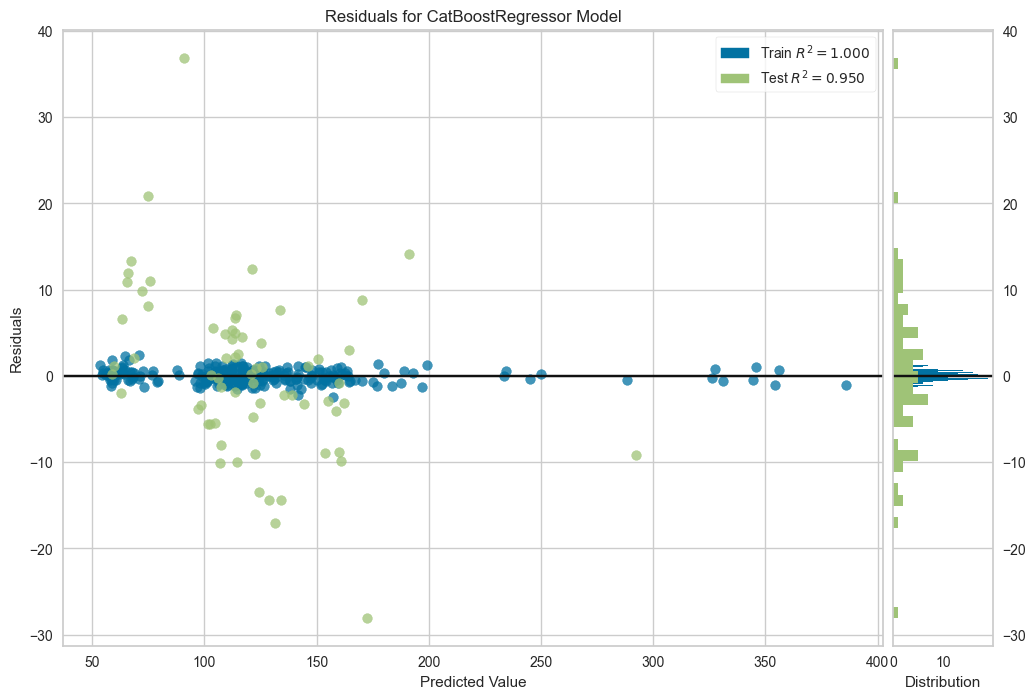

2025-02-17 16:14:49,440 - INFO - Generating Feature Importance (Top 10)



Feature Importance (Top 10):


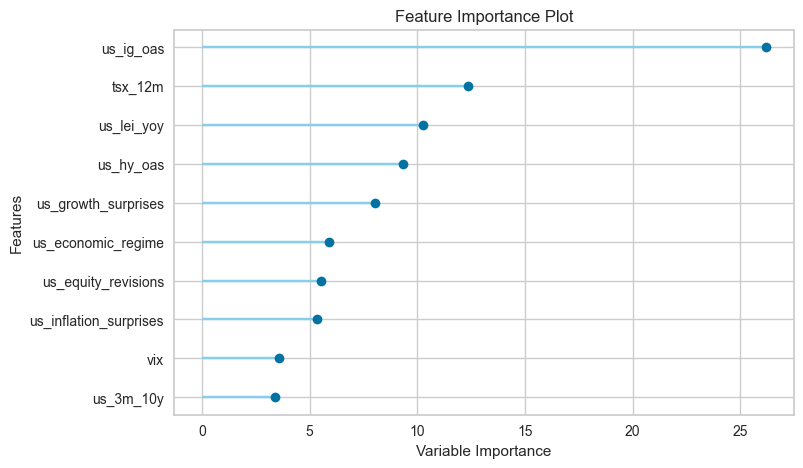

2025-02-17 16:14:49,678 - INFO - Generating Feature Importance (All Features)



Feature Importance (All Features):


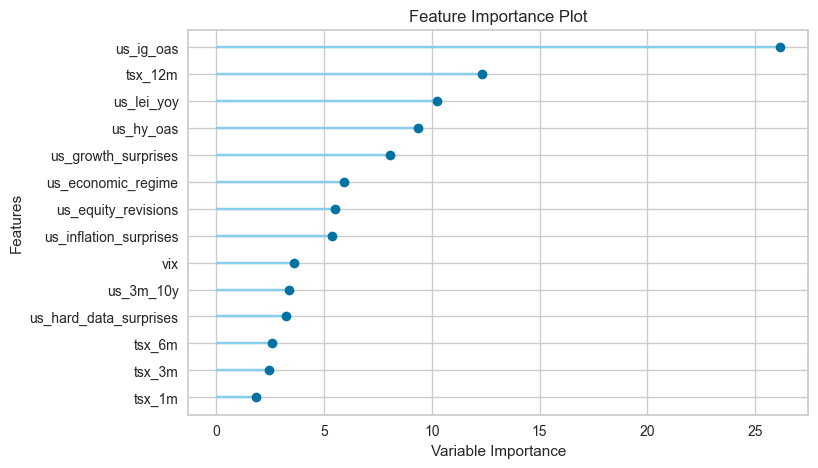

2025-02-17 16:14:49,946 - INFO - Generating Learning Curve



Learning Curve:


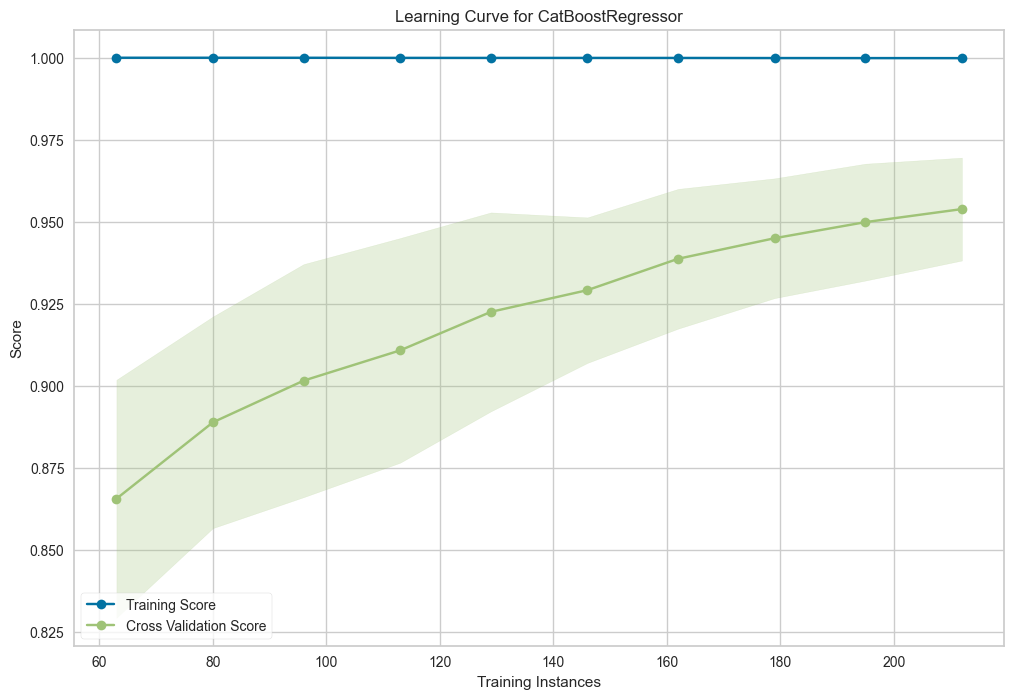

2025-02-17 16:15:05,010 - INFO - Generating Prediction Error Plot



Prediction Error Plot:


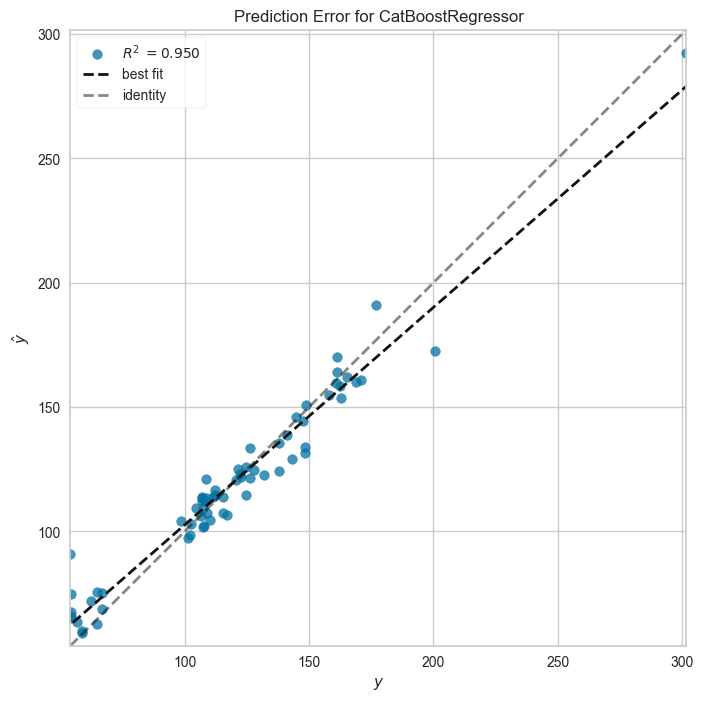

2025-02-17 16:15:05,348 - INFO - Finalizing best model
2025-02-17 16:15:06,593 - INFO - Saving model to c:\Users\Eddy\Documents\auto_ml\notebooks\models\regression_best_model.pkl
2025-02-17 16:15:06,596 - INFO - Model saved successfully
2025-02-17 16:15:06,596 - INFO - Making predictions on test set


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.6697,0.6953,0.8338,0.9997,0.0085,0.0063


2025-02-17 16:15:06,749 - INFO - Predictions saved to c:\Users\Eddy\Documents\auto_ml\notebooks\csv_outputs\cad_oas_predictions.csv



Test Set Performance Metrics:
--------------------------------------------------
Mean Absolute Percentage Error (MAPE): 0.63%
Root Mean Square Error (RMSE): 0.83
Mean Absolute Error (MAE): 0.67
R-squared (R²): 0.9997

Last 5 Predictions vs Actual:
                Actual   Predicted  Difference  Percentage_Error
Date                                                            
2024-10-31  109.779198  110.078849   -0.299651          0.272958
2024-11-29  101.127701  101.935862   -0.808161          0.799149
2024-11-30  101.127701  101.002121    0.125580          0.124180
2024-12-31   98.511703   99.276899   -0.765195          0.776756
2025-01-31  101.619598  100.464304    1.155295          1.136882


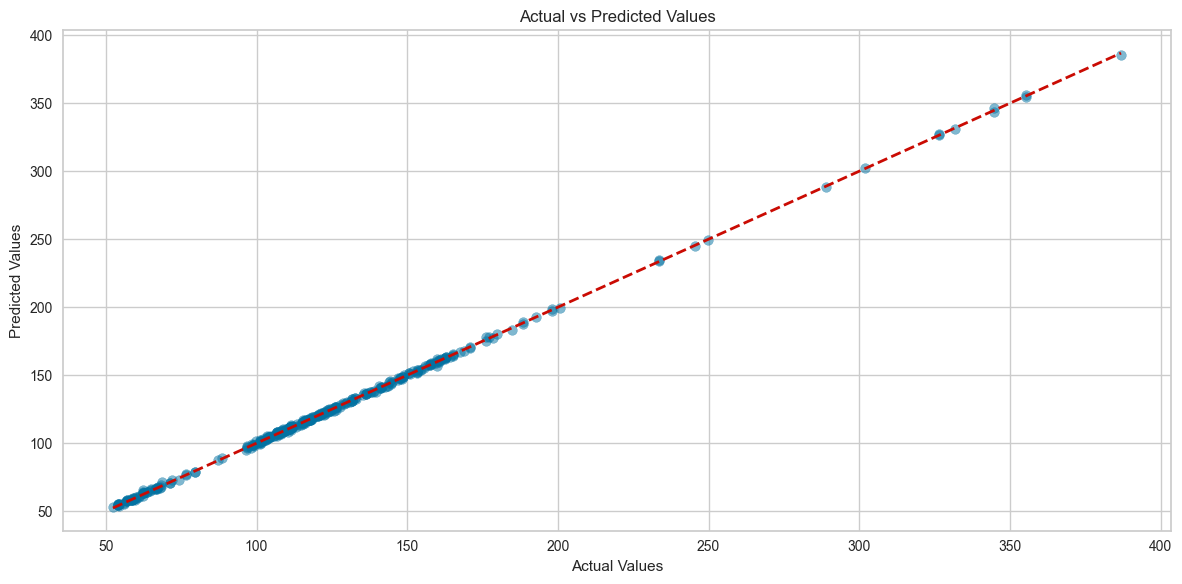

In [9]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
import math
from plotly.subplots import make_subplots
from datetime import datetime
import sys  
from pathlib import Path
from pycaret.regression import *
import shap
import matplotlib.pyplot as plt
import logging
import pickle
import os
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def load_and_prepare_data(file_path):
    """
    Load and prepare the data for regression modeling
    
    Args:
        file_path: Path to the CSV file containing the data
        
    Returns:
        pd.DataFrame: Prepared dataframe with datetime index
    """
    try:
        logging.info(f"Loading data from {file_path}")
        df = pd.read_csv(file_path)
        
        # Convert Date column to datetime and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Sort index to ensure chronological order
        df = df.sort_index()
        
        logging.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

def train_predict_model(data):
    """
    Train a regression model and make predictions with improved feature analysis
    and model selection based on test set performance
    
    Args:
        data: DataFrame with the data
        
    Returns:
        tuple: (final_model, model_metrics)
    """
    try:
        # First, analyze feature correlations
        logging.info("Analyzing feature correlations")
        correlations = data.corr()['cad_oas'].sort_values(ascending=False)
        print("\nFeature Correlations with Target (cad_oas):")
        print(correlations)
        
        # Create correlation heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.show()
        
        logging.info("Initializing model setup")
        s = setup(
            data=data,
            target='cad_oas',
            train_size=0.8,
            fold=5,
            normalize=True,
            transformation=True,
            feature_selection=False,
            remove_multicollinearity=False,
            session_id=123,
            verbose=True
        )
        
        # Print the features being used
        print("\nFeatures being used in the model:")
        print(data.columns.drop('cad_oas').tolist())
        
        # Include models to test
        include = [
            'lr', 'en', 'ridge', 'lasso', 'br',
            'huber', 'omp', 'knn',
            'dt', 'rf', 'et', 'gbr',
            'ada', 'lightgbm', 'catboost'
        ]
        
        # Train all models and evaluate on test set
        logging.info("Training and evaluating models on test set")
        models_metrics = []
        
        for model_name in include:
            try:
                print(f"\nTraining {model_name}...")
                # Create and train model
                model = create_model(model_name, verbose=False)
                
                # Get test set predictions
                test_predictions = predict_model(model)
                
                # Calculate test set metrics
                test_actual = test_predictions['cad_oas']
                test_predicted = test_predictions['prediction_label']
                
                mape = np.mean(np.abs((test_actual - test_predicted) / test_actual)) * 100
                rmse = np.sqrt(np.mean((test_actual - test_predicted) ** 2))
                mae = np.mean(np.abs(test_actual - test_predicted))
                r2 = 1 - (np.sum((test_actual - test_predicted) ** 2) / np.sum((test_actual - test_actual.mean()) ** 2))
                
                models_metrics.append({
                    'model_name': model_name,
                    'model': model,
                    'mape': mape,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2
                })
                
                print(f"Test Set Metrics for {model_name}:")
                print(f"MAPE: {mape:.2f}%")
                print(f"RMSE: {rmse:.2f}")
                print(f"MAE: {mae:.2f}")
                print(f"R²: {r2:.4f}")
                
            except Exception as e:
                logging.warning(f"Error training {model_name}: {str(e)}")
                continue
        
        # Select best model based on RMSE on test set
        best_model_dict = min(models_metrics, key=lambda x: x['rmse'])
        best_model = best_model_dict['model']
        
        print("\nBest Model Performance (Test Set):")
        print(f"Model: {best_model_dict['model_name']}")
        print(f"MAPE: {best_model_dict['mape']:.2f}%")
        print(f"RMSE: {best_model_dict['rmse']:.2f}")
        print(f"MAE: {best_model_dict['mae']:.2f}")
        print(f"R²: {best_model_dict['r2']:.4f}")
        
        # Generate diagnostic plots for best model
        logging.info("Generating diagnostic plots for best model")
        plt.rcParams['figure.figsize'] = [12, 8]
        
        plot_types = [
            ('residuals', 'Residuals Plot'),
            ('feature', 'Feature Importance (Top 10)'),
            ('feature_all', 'Feature Importance (All Features)'),
            ('learning', 'Learning Curve'),
            ('error', 'Prediction Error Plot')
        ]
        
        for plot_type, plot_name in plot_types:
            try:
                logging.info(f"Generating {plot_name}")
                print(f"\n{plot_name}:")
                plot = plot_model(best_model, plot=plot_type, save=False)
                plt.show()
                plt.close()
            except Exception as e:
                logging.warning(f"Could not generate {plot_name}: {str(e)}")
        
        # Finalize the best model
        logging.info("Finalizing best model")
        final_model = finalize_model(best_model)
        
        return final_model, best_model_dict
        
    except Exception as e:
        logging.error(f"Error in model training/prediction: {str(e)}")
        raise

def save_model_to_pkl(model, filename='regression_best_model.pkl'):
    """
    Save a trained model to a pickle file
    """
    try:
        os.makedirs('models', exist_ok=True)
        model_path = os.path.join('models', filename)
        logging.info(f"Saving model to {os.path.abspath(model_path)}")
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        logging.info("Model saved successfully")
    except Exception as e:
        logging.error(f"Error saving model to pickle file: {str(e)}")
        raise

def analyze_model_performance(model, data):
    """
    Analyze model performance metrics and make predictions
    """
    try:
        # Get predictions on test set
        logging.info("Making predictions on test set")
        predictions = predict_model(model, data=data)
        
        # Save predictions
        csv_path = 'csv_outputs/cad_oas_predictions.csv'
        os.makedirs(os.path.dirname(csv_path), exist_ok=True)
        predictions.to_csv(csv_path)
        logging.info(f"Predictions saved to {os.path.abspath(csv_path)}")
        
        # Calculate and display metrics
        actual = predictions['cad_oas']
        predicted = predictions['prediction_label']
        
        # Calculate metrics
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        rmse = np.sqrt(np.mean((actual - predicted) ** 2))
        mae = np.mean(np.abs(actual - predicted))
        r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - actual.mean()) ** 2))
        
        print("\nTest Set Performance Metrics:")
        print("-" * 50)
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"R-squared (R²): {r2:.4f}")
        
        # Print last predictions
        print("\nLast 5 Predictions vs Actual:")
        comparison_df = pd.DataFrame({
            'Actual': actual.tail(),
            'Predicted': predicted.tail(),
            'Difference': (actual - predicted).tail(),
            'Percentage_Error': (np.abs((actual - predicted) / actual) * 100).tail()
        })
        print(comparison_df)
        
        # Plot actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.scatter(actual, predicted, alpha=0.5)
        plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logging.error(f"Error analyzing model performance: {str(e)}")
        raise

def main():
    """
    Main function to orchestrate the model training and prediction process
    """
    try:
        # File path
        file_path = 'c:/Users/Eddy/Documents/auto_ml/csv_outputs/monthly_oas_pycaret.csv'
        
        # Load and prepare data
        data = load_and_prepare_data(file_path)
        
        # Train model and get predictions
        model, metrics = train_predict_model(data)
        
        # Save the model to pickle file
        save_model_to_pkl(model, 'regression_best_model.pkl')
        
        # Analyze model performance
        analyze_model_performance(model, data)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()